In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from bs4 import BeautifulSoup as bs

import pandas as pd
import time

In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)

In [3]:
service = Service(executable_path=ChromeDriverManager().install())

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.29M/6.29M [00:00<00:00, 53.6MB/s]


In [5]:
def get_comments(service, df, webtoon_id, episode_no):
    TIMEOUT = 1   
    driver = webdriver.Chrome(service=service)
    
    url = 'https://comic.naver.com/webtoon/detail?'
    episode_url = url + 'titleId=' + str(webtoon_id) + '&no='+str(episode_no)
    print(episode_url)
    driver.get(episode_url) # 새창 열기
    driver.implicitly_wait(TIMEOUT)
    
    # 댓글창에 해당하는 프레임 선택
    driver.switch_to.frame('commentIframe')
    
    # 수집 편의를 위한 클린봇 댓글 필터링 기능 해제
    # (클린봇이 부적절한 표현을 감지한 댓글입니다.) 제거
    driver.find_element(By.CLASS_NAME,'u_cbox_cleanbot_setbutton').click()
    time.sleep(0.4)
    driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_checkbox').click()
    time.sleep(0.4)
    driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_extrabtn').click()
    time.sleep(0.4)

    # 전체 댓글 클릭
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_view_comment > a').click()
    time.sleep(1)
    
    # "맨뒤" 클릭하여 전체 페이지 수 조회
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end > span.u_cbox_cnt_page').click()
    time.sleep(1)
    strong = driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > strong')
    num_pages = strong.get_attribute('data-param')  # class_ = a.get_attribute('class')
    print("num_pages: ", num_pages)     
    
    # "맨앞" 으로 이동
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_pre.u_cbox_pre_end > span.u_cbox_cnt_page').click()
    time.sleep(1)
    
    # 0 ~ 818
    for page in range(int(num_pages)):

        #최근 열린 탭으로 전환
        driver.switch_to.window(driver.window_handles[-1]) 
        driver.switch_to.frame("commentIframe")
        soup = bs(driver.page_source,"html.parser")

        # 날짜 추출
        dates = soup.findAll("span", {"class":["u_cbox_date"]})
        dates = [date.text for date in dates]        

        # 삭제된 댓글 제외하고 모든 댓글 추출
        reviews = soup.findAll("span", {"class":["u_cbox_contents"]})
        reviews = [review.get_text() for review in reviews]

        df_page = pd.DataFrame(data=[], columns=['에피소드','날짜','댓글'])
        df_page['날짜'] = dates
        df_page['댓글'] = reviews
        df_page['에피소드'] = df_page['에피소드'].fillna(episode_no) 
        
        df = pd.concat([df,df_page])      
        print(page+1, " page Done.")        

        if (page+1) == int(num_pages):
            return df
        
        # 다음 페이지로 이동
        driver.find_element(By.CSS_SELECTOR, "#cbox_module > div > div.u_cbox_paginate > div > strong + a").click()        
        time.sleep(0.4)
    driver.close()
    return df

df = pd.DataFrame(data=[], columns=['에피소드','날짜','댓글'])
df = get_comments(service, df, 747269, 67) # 전지적 독자 시점 - 에피소드 1
df

df.to_csv("전체댓글.csv",index = False)

https://comic.naver.com/webtoon/detail?titleId=747269&no=67
num_pages:  268
1  page Done.
2  page Done.
3  page Done.
4  page Done.
5  page Done.
6  page Done.
7  page Done.
8  page Done.
9  page Done.
10  page Done.
11  page Done.
12  page Done.
13  page Done.
14  page Done.
15  page Done.
16  page Done.
17  page Done.
18  page Done.
19  page Done.
20  page Done.
21  page Done.
22  page Done.
23  page Done.
24  page Done.
25  page Done.
26  page Done.
27  page Done.
28  page Done.
29  page Done.
30  page Done.
31  page Done.
32  page Done.
33  page Done.
34  page Done.
35  page Done.
36  page Done.
37  page Done.
38  page Done.
39  page Done.
40  page Done.
41  page Done.
42  page Done.
43  page Done.
44  page Done.
45  page Done.
46  page Done.
47  page Done.
48  page Done.
49  page Done.
50  page Done.
51  page Done.
52  page Done.
53  page Done.
54  page Done.
55  page Done.
56  page Done.
57  page Done.
58  page Done.
59  page Done.
60  page Done.
61  page Done.
62  page Done.
63 

In [6]:
df

,에피소드,날짜,댓글
0,67,2일 전,지린다 와.. 와우
1,67,2일 전,와 .
2,67,3일 전,크으 설화 왕이 없는 세계의 왕 연출 미쳤다
3,67,4일 전,와 죽어
4,67,4일 전,막컷 너무 예뻐
...,...,...,...
9,67,2021-07-27 22:52,50분부터 대기탄사람 저용!! 했는데 이미올라와잇어..
10,67,2021-07-27 22:51,오우오우
11,67,2021-07-27 22:51,엥 뭐지
12,67,2021-07-27 22:51,오


In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
import numpy as np

In [8]:
# 문자열 아닌 데이터 모두 제거
df_review = [review for review in df['댓글'] if type(review) is str]
df_review

['지린다 와.. 와우',
 '와 .',
 '크으 설화 왕이 없는 세계의 왕 연출 미쳤다',
 '와 죽어',
 '막컷 너무 예뻐',
 '이번화 미쳣네 진짜',
 '와 진짜 연출 미쳤다.... 가슴이 웅장해진다...',
 'ㅜㅠㅠ하',
 'ㄹㅈㄷ 나 지림',
 '독자 너무 잘생겼다',
 '진지하게 고찰해봤을때 독자는 중혁이랑은 다른 미인. 중혁이는 화려하게 생기고 감탄이 나오는 미인이고 우리 독자는 단아하잖아',
 '미친…',
 '캬',
 '아니 이 전체가 문학, 역사의 흐름을 바탕으로 한다는게 날 미치게 해요.........',
 '찢었다',
 '막컷 김독자 퇴폐미 개지리는데 내가 알던 김독자가 맞습니까?',
 '아니 왜 마지막에 전독시 로고? 비에 젖은거 왜 이야기 안해?',
 '와 개 멋있다ㅠㅠㅠ 진짜 눈물ㅠㅠㅠㅠ 모든 별이 독자를 바라보고 있는것 같은 표현이 진짜 찢었다',
 '북두칠성의 7성군',
 '개멋있어 ㅁㅊ',
 '막컷 진짜 미쳤다,,,, 제목표현봐 와,,,',
 '아 말이 안 나온다마지막에 있는 번진 연출도 너무 좋고...... 아니 그냥 다 좋아........',
 '와 화면 90도 돌려서 보고 180도 돌려서 보고 270도 돌려서 보고 원래대로 한번 더 보고 눈 비볐다가 봐도 예쁘다',
 '독자씨 넘 잘생김',
 '어제보고 진짜 여기까지 달려왔다.. 그냥 미쳤다',
 '존나재밌네',
 '내가 살다살다 판타지 웹툰 보다가 오열하네... 드디어 내가 미쳤나보다',
 '독자가 단지 이야기를 아는 것 뿐 아니라 무척 현명하고 용감하기 때문에 가능한 일. 평범한 세계에서도 잘 살았을 것 같은데..',
 '왕이 없는 세계의 왕',
 '와... 소름에 소름에 또 소름이다',
 '새삼 독자 넘 이뿌게 생김 ㅠㅠ!!!',
 '미쳤다 진짜..! ',
 '내최애 화......,너무조아ㅜㅜㅜㅜ',
 '와 너무좋다 왕이없는 세계의 왕',
 '근데 용존이 아니고 용준 아닌가요.. 용모양 항아리...',
 '와미쳤다 진짜 소름돋고 몰입도 최강이고 이런 웹툰 왜이제알아

In [9]:
#구두점등 특수문자 [!”#$%&’()*+,-./:;<=>?@[]^_`{|}~]  제거

import string
translator = str.maketrans('','',string.punctuation)
result = str(df_review).translate(translator)
print(result)

지린다 와 와우 와  크으 설화 왕이 없는 세계의 왕 연출 미쳤다 와 죽어 막컷 너무 예뻐 이번화 미쳣네 진짜 와 진짜 연출 미쳤다 가슴이 웅장해진다 ㅜㅠㅠ하 ㄹㅈㄷ 나 지림 독자 너무 잘생겼다 진지하게 고찰해봤을때 독자는 중혁이랑은 다른 미인 중혁이는 화려하게 생기고 감탄이 나오는 미인이고 우리 독자는 단아하잖아 미친… 캬 아니 이 전체가 문학 역사의 흐름을 바탕으로 한다는게 날 미치게 해요 찢었다 막컷 김독자 퇴폐미 개지리는데 내가 알던 김독자가 맞습니까 아니 왜 마지막에 전독시 로고 비에 젖은거 왜 이야기 안해 와 개 멋있다ㅠㅠㅠ 진짜 눈물ㅠㅠㅠㅠ 모든 별이 독자를 바라보고 있는것 같은 표현이 진짜 찢었다 북두칠성의 7성군 개멋있어 ㅁㅊ 막컷 진짜 미쳤다 제목표현봐 와 아 말이 안 나온다마지막에 있는 번진 연출도 너무 좋고 아니 그냥 다 좋아 와 화면 90도 돌려서 보고 180도 돌려서 보고 270도 돌려서 보고 원래대로 한번 더 보고 눈 비볐다가 봐도 예쁘다 독자씨 넘 잘생김 어제보고 진짜 여기까지 달려왔다 그냥 미쳤다 존나재밌네 내가 살다살다 판타지 웹툰 보다가 오열하네 드디어 내가 미쳤나보다 독자가 단지 이야기를 아는 것 뿐 아니라 무척 현명하고 용감하기 때문에 가능한 일 평범한 세계에서도 잘 살았을 것 같은데 왕이 없는 세계의 왕 와 소름에 소름에 또 소름이다 새삼 독자 넘 이뿌게 생김 ㅠㅠ 미쳤다 진짜  내최애 화너무조아ㅜㅜㅜㅜ 와 너무좋다 왕이없는 세계의 왕 근데 용존이 아니고 용준 아닌가요 용모양 항아리 와미쳤다 진짜 소름돋고 몰입도 최강이고 이런 웹툰 왜이제알아서 첫화부터 지금까지 쉬지않고 계속보는데 이건 댓글달아야된다 작가님 천재신가봐요 응원합니다 최고예요 진짜 미쳤어요 와 ❤️ 와진짜 소름돋았다 독자야 낭만 오도깨뷔 이 놈 무섭구나 오열중 일곱 번째 보는데 일곱 번 전부 눈물 질질 ㅇ0ㅇ 바라본다 성좌들이 개연성 가져가는 부분 눈물나도록 감동 ㅠㅠ 와 진짜 소름이 몇번 돋는거냐선생님들 혹시 이거 책 원작은 완결이 되어있나요 첫 주행자지만

In [13]:
# 반복어 삭제
from soynlp.normalizer import *

result = emoticon_normalize(result, num_repeats=2)
result

'지린다 와 와우 와 크으 설화 왕이 없는 세계의 왕 연출 미쳤다 와 죽어 막컷 너무 예뻐 이번화 미쳣네 진짜 와 진짜 연출 미쳤다 가슴이 웅장해진다 ㅜㅠㅠ하 ㄹㅈㄷ 나 지림 독자 너무 잘생겼다 진지하게 고찰해봤을때 독자는 중혁이랑은 다른 미인 중혁이는 화려하게 생기고 감탄이 나오는 미인이고 우리 독자는 단아하잖아 미친… 캬 아니 이 전체가 문학 역사의 흐름을 바탕으로 한다는게 날 미치게 해요 찢었다 막컷 김독자 퇴폐미 개지리는데 내가 알던 김독자가 맞습니까 아니 왜 마지막에 전독시 로고 비에 젖은거 왜 이야기 안해 와 개 멋있다ㅠㅠㅠ 진짜 눈물ㅠㅠ 모든 별이 독자를 바라보고 있는것 같은 표현이 진짜 찢었다 북두칠성의 7성군 개멋있어 ㅁㅊ 막컷 진짜 미쳤다 제목표현봐 와 아 말이 안 나온다마지막에 있는 번진 연출도 너무 좋고 아니 그냥 다 좋아 와 화면 90도 돌려서 보고 180도 돌려서 보고 270도 돌려서 보고 원래대로 한번 더 보고 눈 비볐다가 봐도 예쁘다 독자씨 넘 잘생김 어제보고 진짜 여기까지 달려왔다 그냥 미쳤다 존나재밌네 내가 살다살다 판타지 웹툰 보다가 오열하네 드디어 내가 미쳤나보다 독자가 단지 이야기를 아는 것 뿐 아니라 무척 현명하고 용감하기 때문에 가능한 일 평범한 세계에서도 잘 살았을 것 같은데 왕이 없는 세계의 왕 와 소름에 소름에 또 소름이다 새삼 독자 넘 이뿌게 생김 ㅠㅠ 미쳤다 진짜 내최애 화너무조아ㅜㅜ 와 너무좋다 왕이없는 세계의 왕 근데 용존이 아니고 용준 아닌가요 용모양 항아리 와미쳤다 진짜 소름돋고 몰입도 최강이고 이런 웹툰 왜이제알아서 첫화부터 지금까지 쉬지않고 계속보는데 이건 댓글달아야된다 작가님 천재신가봐요 응원합니다 최고예요 진짜 미쳤어요 와 ❤️ 와진짜 소름돋았다 독자야 낭만 오도깨뷔 이 놈 무섭구나 오열중 일곱 번째 보는데 일곱 번 전부 눈물 질질 ㅇ0ㅇ 바라본다 성좌들이 개연성 가져가는 부분 눈물나도록 감동 ㅠㅠ 와 진짜 소름이 몇번 돋는거냐선생님들 혹시 이거 책 원작은 완결이 되어있나요 첫 주행자지만 벌써 현

In [35]:
def text_preprocessor(s): 
    import re
    #1. [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\[[^]]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\<[^>]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\{[^}]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)   
    
    #2. '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')

    #3. 특수문자, 숫자 제거
    pattern = r'[^a-zA-Z가-힣]'
    s = re.sub(pattern=pattern, repl=' ', string=s)

    #4. 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')

    #5. 공백 기준으로 토큰화
    s_split = s.split()
    

    #6. 글자길이 1이면 제외(삭제)
    #return 리스트객체
    s_list = []
    for word in s_split:
        if len(word) !=1:
            s_list.append(word)
            
    
    
    return s_list

In [36]:
clean = text_preprocessor(result)
clean

['지린다',
 '와우',
 '크으',
 '설화',
 '왕이',
 '없는',
 '세계의',
 '연출',
 '미쳤다',
 '죽어',
 '막컷',
 '너무',
 '예뻐',
 '이번화',
 '미쳣네',
 '진짜',
 '진짜',
 '연출',
 '미쳤다',
 '가슴이',
 '웅장해진다',
 '지림',
 '독자',
 '너무',
 '잘생겼다',
 '진지하게',
 '고찰해봤을때',
 '독자는',
 '중혁이랑은',
 '다른',
 '미인',
 '중혁이는',
 '화려하게',
 '생기고',
 '감탄이',
 '나오는',
 '미인이고',
 '우리',
 '독자는',
 '단아하잖아',
 '미친',
 '아니',
 '전체가',
 '문학',
 '역사의',
 '흐름을',
 '바탕으로',
 '한다는게',
 '미치게',
 '해요',
 '찢었다',
 '막컷',
 '김독자',
 '퇴폐미',
 '개지리는데',
 '내가',
 '알던',
 '김독자가',
 '맞습니까',
 '아니',
 '마지막에',
 '전독시',
 '로고',
 '비에',
 '젖은거',
 '이야기',
 '안해',
 '멋있다',
 '진짜',
 '눈물',
 '모든',
 '별이',
 '독자를',
 '바라보고',
 '있는것',
 '같은',
 '표현이',
 '진짜',
 '찢었다',
 '북두칠성의',
 '성군',
 '개멋있어',
 '막컷',
 '진짜',
 '미쳤다',
 '제목표현봐',
 '말이',
 '나온다마지막에',
 '있는',
 '번진',
 '연출도',
 '너무',
 '좋고',
 '아니',
 '그냥',
 '좋아',
 '화면',
 '돌려서',
 '보고',
 '돌려서',
 '보고',
 '돌려서',
 '보고',
 '원래대로',
 '한번',
 '보고',
 '비볐다가',
 '봐도',
 '예쁘다',
 '독자씨',
 '잘생김',
 '어제보고',
 '진짜',
 '여기까지',
 '달려왔다',
 '그냥',
 '미쳤다',
 '존나재밌네',
 '내가',
 '살다살다',
 '판타지',
 '웹툰',
 '보다가',
 '오열하네',
 '드디어',
 '내가',
 '미쳤나보다',
 

In [37]:
stopwords = ['진짜','너무']

In [39]:
import nltk

for i, document in enumerate(clean):
    clean_words = [] 
    for word in nltk.tokenize.word_tokenize(document): 
        if word not in stopwords: #불용어 제거
            clean_words.append(word)
    print(clean_words) 
    clean[i] = ' '.join(clean_words)    

['지린다']
['와우']
['크으']
['설화']
['왕이']
['없는']
['세계의']
['연출']
['미쳤다']
['죽어']
['막컷']
[]
['예뻐']
['이번화']
['미쳣네']
[]
[]
['연출']
['미쳤다']
['가슴이']
['웅장해진다']
['지림']
['독자']
[]
['잘생겼다']
['진지하게']
['고찰해봤을때']
['독자는']
['중혁이랑은']
['다른']
['미인']
['중혁이는']
['화려하게']
['생기고']
['감탄이']
['나오는']
['미인이고']
['우리']
['독자는']
['단아하잖아']
['미친']
['아니']
['전체가']
['문학']
['역사의']
['흐름을']
['바탕으로']
['한다는게']
['미치게']
['해요']
['찢었다']
['막컷']
['김독자']
['퇴폐미']
['개지리는데']
['내가']
['알던']
['김독자가']
['맞습니까']
['아니']
['마지막에']
['전독시']
['로고']
['비에']
['젖은거']
['이야기']
['안해']
['멋있다']
[]
['눈물']
['모든']
['별이']
['독자를']
['바라보고']
['있는것']
['같은']
['표현이']
[]
['찢었다']
['북두칠성의']
['성군']
['개멋있어']
['막컷']
[]
['미쳤다']
['제목표현봐']
['말이']
['나온다마지막에']
['있는']
['번진']
['연출도']
[]
['좋고']
['아니']
['그냥']
['좋아']
['화면']
['돌려서']
['보고']
['돌려서']
['보고']
['돌려서']
['보고']
['원래대로']
['한번']
['보고']
['비볐다가']
['봐도']
['예쁘다']
['독자씨']
['잘생김']
['어제보고']
[]
['여기까지']
['달려왔다']
['그냥']
['미쳤다']
['존나재밌네']
['내가']
['살다살다']
['판타지']
['웹툰']
['보다가']
['오열하네']
['드디어']
['내가']
['미쳤나보다']
['독자가']
['단지']
['이야기를']
['아는']
['아니라'

[]
['미쳣네']
['와진짜개미쳣다']
[]
['그냥']
['매화가']
['미쳤어']
['번째']
['베댓']
['다음에']
['소설로']
['봐야겠다']
['왤케']
['섹시하냐']
['막컷']
['독자']
[]
['예쁘자나']
['찟었다']
['개연성']
['나눠가질때']
['별들']
['반짝거리는거']
['쁘다']
['이야']
['어떡해']
['나도']
['같이']
['바라봐주고']
['싶을정도로']
[]
['착하고']
['마음이']
['너무예뻐']
[]
['소름돋는건']
['한둘아닌거같은데']
['뭔가']
['울컥하면']
['눈물나는건']
['나뿐인가']
['온몸에']
['소름이']
['돋았습니다']
['이번화']
['레전드']
['머리가']
['쭈뼜쭈뼜']
['소오오오름']
['돋았다']
['마지막컷']
['졸라']
['잘생겼어']
['소설판으로']
['봤을때도']
['웅장해졌는데']
['만화도']
['그렇네물론']
['아직까진']
['소설판보다']
['전율은']
['적은듯n만화의']
['연출이']
['모자르다기보다n애초에']
['인간의']
['상상력']
['보다']
['빠르고']
['정확하고']
['디테일하게']
['그릴수있는']
['만화가']
['없다보니']
['그런것같음']
['뭡니까']
['대작은']
['소름돋았엉']
['키야']
['와웹툰에서']
['오니까']
['전지적']
['독자시점']
['로고']
['비에']
['젖은']
['걸로']
['표현한거']
[]
['개멋지네']
['후아']
['약간']
['소설볼때']
['이부분']
['성좌들이']
['한명씩']
['뒤돌아보면서']
['차례로']
['대답하는']
['장면']
['상상했는데']
['여기선']
['별이']
['반짝이넴']
['이케']
['다른']
['구도로']
['보는것도']
['재밌는듯']
['이제']
['여정을']
['떠나보자고']
['독자야']
['막컷']
['김독자']
['왤케']
['이쁜겨']
['독자']
['설화']
['만든거면']
['나중에']
['독자']
['죽으면'

['소름']
['돋음']
['어떻게']
['연출할까']
['했는데']
['대박이다']
['진짜소설']
['정주행']
['다시']
['하러가야겠다']
['하대박이다']
['이제']
['주인공']
['마누라']
['나올']
['차례인가']
['왕이']
['없지만']
['왕이']
['있는']
[]
['소름돋아']
['그림작가님']
['그림이고']
['연출이고']
['하나']
['빠지는']
['없다']
[]
['최고의']
['그림작가님']
['진짜소름돋아작가님최고']
['보자마자']
['개간지']
['난다']
['이말']
['부터']
['나왔다']
['개연성']
['나눠받아주눈거']
[]
['감동적이야']
[]
['여기까지']
['기다렸는데']
[]
['감격스러워']
['눈물나']
['성좌들']
['아니였으면']
['전지적']
['독자시점을']
['사랑해주셔서']
['감사합니다']
['김독자']
['섹시허다']
['웅장하다']
['그렇게']
['독자의']
['설화가']
['생겼다']
['김독자와막컷']
['이뻐연출']
['미쳤다']
['애니도']
['만들어지면']
['좋겠다']
['와중에']
['제일']
['먼저']
['도와주는']
['해상전신']
['역시']
['장군님이라']
['이건가']
['멋있네']
['독자야']
[]
['예쁘다']
['오늘도']
['소름']
['돋고']
['뽕찬다']
['김독자의']
['설화에']
['소설']
['원작']
['작년에']
['전부']
['정주행한']
['사람으로서']
['방금']
['왕이']
['없는']
['세계의']
['설화']
['나오는']
['장면']
['찐으로']
['소름']
['돋았습니다']
['스토리']
['미쳤다']
['편부터']
['정주행']
['했는데']
['정말']
['진심']
['너무너무']
['재밌었다']
[]
['재밌어요']
['감동']
['감동']
['짱짱']
['멋져요']
['이계의']
['신격']
['도르마무']
['같은']
['얘들인가요']
['여기까지']
['이야기가']
['소설']
['몇화인가요

[]
['좋아요']
['어떡게성좌들이']
['도와준다n사랑받고']
['있네']
['나도']
['좋아한다']
['아아']
['우리나라']
['성좌들']
['짱이지요']
['그와중에']
['우리']
['이순신장군님']
['제일']
['먼저']
['개연성부담']
['나눠가주는거']
[]
['좋구요']
['우리']
['장군님']
['짱이야']
['흠아직까지도']
['독자는']
['알몸에다가']
['희원이가준']
['티만입고는데작가님']
['독자']
['언제']
['옷입히실건가요']
['좋다']
['아주좋아']
['원작']
['감동']
['그대로다']
['이게']
['이렇게']
['묘사가']
['되네']
['막컷']
['독자']
['개이뻐']
['미친']
['뭐야']
['개연성']
['감당해주다가']
['대머리될뻔']
['미친']
['도랐다']
['글작가님이나']
['그림작가님이나']
['둘다']
['천재다']
['저게']
['유중혁이']
['걸어온길인가']
['독자야']
[]
['예쁘다']
[]
['여운']
['남는다그림체']
['오지고']
['스토리']
['오지고']
[]
['웹툰이']
['설화다']
['감정을']
['말로']
['표현할']
['없음']
['찢었다진짜']
['울컥울었다']
['도깨비']
['빡친']
['표현력은']
[]
['웹툰에서']
['최고인듯']
['미뗬따']
['작가님']
[]
[]
['완전']
['정말']
['사랑해요최고야']
['와느낌이']
['이상하네요']
['소설']
['끝까지']
['다읽은']
['독자로서n뭔가']
['소설읽을때는']
['우와']
['했던것들이n']
[]
['애정하는']
['위소설로']
['완독하고n웹툰으로']
['보니깐왜찡']
['n저같은분']
['없으신가요n왠지']
['마음이']
['웅장하고']
['찡하고']
['짠하고nn뭐시라고']
['출근길에']
['울뻔']
['미쳤다진짜']
['한마디밖에']
['안나온다']
[]
['전독시는']
['매화가']
['레전드네']
['기존']
['소설이']
['튼튼하기도']
['하

['없었는데']
['작품보고']
['특히']
['이번화']
['보고']
['느꼈다']
['특히']
['원작의']
['내용을']
['따르는']
['것에서']
['멈추지']
['않고']
['웹툰에서']
['강조해줄']
['있는']
['연출이']
['어떤']
['것인지']
['고심하고']
['제작하는게']
['느껴져서']
['좋았다']
['노브랜드']
['인가']
['이게']
[]
['웹툰의']
['완벽한']
['모습인듯']
['약간']
['짧은']
['느낌이였지만']
['엄청']
['강렬했음']
['온몸에']
['전율이']
['흐르고']
['심장이']
['움직이는게']
['느껴짐']
[]
['짧고']
['강렬함이']
['뭔지']
['알려주는듯n웹툰화']
['소설중']
['이게']
[]
['찐이다']
[]
['웹툰보면서']
['처음으로']
['몸에']
['소름돋는']
['전율을']
['느낌']
['웹툰보다']
['소름돋은거']
['처음이야']
[]
['가슴이']
['웅장해진다']
['소설로']
['보고']
['만화로봐도']
['소름돋아']
['미친']
['존나']
['머시써']
['웹툰보면서']
['이렇게']
['연속적으로']
['소름돋긴']
['처음']
['이게']
['프롤로그라니']
['연출']
['몰입감']
['미쳤네']
['이거지']
['재밌어뭐라해야될진']
['모르겠는데']
['일단']
['재밌음']
['분량이']
['순삭']
['열린교회']
['참고로']
['웹툰은']
['정도로']
['아직']
['완결나려면']
['남았습니다']
['김독자이러고못생겻다고하']
['절대는']
['절대']
['있을']
['없지']
['절대가']
['절대']
['존재할']
['없다는']
['것을']
['제외한다면n절대를']
['자처했으니']
['그에']
['상응한']
['대가로']
['결말을']
['없게']
['만든다']
['이건가nn영원은']
['영원히']
['실존할']
['없다는']
['것과']
['비슷한']
['끼야아아아악드디어']
['성좌들']
['도와주는']
[]
[

['천재야']
['레전드오브레전드한']
['장면을']
['드디어']
['보게']
['되네']
['갑자기']
['분위기']
['코스믹']
['호러행']
['미지의']
['신격이라']
['외신인가']
['소름끼치게']
['재미있네요']
['겨우']
['원이지만']
['전혀']
['아깝지']
['않은']
['소비였다']
['파이어']
['에그가']
['요동친다']
[]
['대작이다']
['원작자도']
['겁나']
['뿌득할듯']
['독자']
[]
['잘생긴']
['아니냐']
['미쳤다']
['개소름진짜']
['김독자']
['도라이야']
['도라이야']
['우리가']
['그대를']
['지켜보겠다']
['왕이']
['없는']
['세계의']
['왕이여']
['지금껏']
['중에']
['가장']
['감동적인']
['화였다']
['진심']
['성좌들이']
['개연성']
['감소해']
['주는']
['부분']
['소름']
['돋았어']
['미침']
['와nnn플']
['설화']
['등장']
['절대왕좌가']
[]
['빨리']
['깨졌네']
['긴박하게']
['부셔줘야']
['되는데']
['숨도']
['쉬고']
['봤네']
['이건']
['결제하길']
['잘했다']
['좀아니']
['많이']
['완전짱짱미친것같음']
['멋있다']
['이걸']
['소장을']
['안하다니']
['하미쳐김독자나지금상상도못할말이손끝에맴도는데굿플레이스에떨어닌배드플레이스맨마녕순한말밖에못해서미쳐버려독자다해하고싶은거싹다해']
['중혁이']
['아직도']
['기절해']
['있니']
['정말']
['소설로']
['때도']
['소름']
['돋았는데웹툰']
['연출']
['미친다']
['설화']
[]
['독자']
['개멋있어']
['찢었다']
['그대의']
['의지를']
['존중한다']
['여기서']
['쿠키를']
['쓰더라도']
['우리가']
['그대를']
['기억할']
['것이다']
['가슴이']
['웅장해진다']
['미친미쳤다미쳤다']
['이번편']
['소장하길']
['잘했다']
['와씨']
['마지막에']


['오래']
['해주세요']
['이부분']
['읽을때']
['소름끼쳤는데']
['웹툰으로보니']
['울컥하네']
['이번화로인해']
['전독시']
['소설을']
['다보게되고']
[]
['역대급']
['수작']
['성좌']
['쿠키굽는검은소이']
['당신을']
['바라봅니다']
['이날을']
['위해']
['쿠키를']
['구웠다']
['와진짜연출짱']
['와씨']
['멋있다']
[]
['프롤로그']
['드립치는거']
['같죠']
[]
['프롤로그']
['맞습니다']
['레전드']
['광고']
['원신무엇']
['광고만']
['캡처하게해줘요']
['잘어울려']
['지금까지']
['나온']
['성좌들']
['김독자']
['특성창']
['댓글']
['처음']
['남겨요']
['웹툰은']
['읽고']
['있으면']
['소설']
['나아가서']
['마치']
['동영상을']
['보는']
['것처럼']
['장면']
['속에']
['독자가']
['빨려들어가는']
['힘이']
['있는']
['같아요완결까지']
['부탁드립니다']
['쿠키가']
['아까운']
['적은']
['이번이']
['처음이야']
[]
['재밌어']
['진심으로']
['앞으로']
['나올']
['모든']
['에피소드가']
['기대됩니다']
['작가님']
['사랑합니다']
['전세계적으로']
['주인공이']
['유일하게']
['왕좌를']
['거부한']
['왕이겠네요']
['애니메이선으로']
['만들면']
['귀칼보다']
['재밌을거같오']
[]
['미쳤다']
['울컥했다']
['책으로']
['본것을']
['행동으로']
['옮기는']
['현명함에']
['미쳣다']
[]
['미쳣네']
['와아']
['연출']
['유중혁']
['갈긴다']
['잼난다']
[]
['재밌다']
['참고']
['기다리려다가']
['못참고']
['쿠키']
['싹다']
['결제하고']
['이건']
['영구소장까지']
['미쳤다진짜']
['역대급']
['작품이었어']
['이거보고']
['소설도다봤다']
['왕이없는']
['세계의']
['그럼'

['n독자']
['n오오']
['독자라네']
['와소설로']
['이미']
['여러번']
['봣지만']
[]
['름이드']
['개쌋다진짜']
['이제']
['시작인가요']
['이야아']
['이게']
['프롤로그에요']
['소설로만']
['읽던']
['내용을']
['그림으로']
['보니']
[]
['앞으로']
['연출']
[]
['기대되는데']
['드디어']
['첫번째']
['설화가']
['나타났다빨리']
['와라']
['설화']
['빨리']
['모으자n']
['스포']
['독자']
['싱숑']
['작가를']
['채찍질']
['합니다']
['구워']
['구우란']
['말이다']
['해상전신']
['성흔']
['처음으로']
['나올']
['때랑']
['별의']
['메아리랑']
['이번']
['화까지']
['지금까지']
['보면서']
['연출에']
['놀란']
['적이']
['여러번인데']
['정말']
['대단하다']
['웹툰의']
['연출에']
['이렇게까지']
['감탄한']
['전독시가']
['처음인듯']
['이번화']
['보다가']
['울컥함']
['소설도']
['보고']
['싶어진다']
['작가님']
['비형좀']
['내보내주세요']
['드디어']
['부쉈네']
['울지']
['마지막씬']
['독자']
['미모']
['미쳤냐']
['권율']
['장군도']
['있구나']
['그와중에']
['성좌']
['일곱명이라서']
['말풍선']
['일곱개']
['겹쳐지는거']
['막컷']
['신발이라능']
['막컷']
['독자야']
['척추측만증']
['걸렸구나']
['이거']
['원작에서는']
['하얀불꽃에']
['귀에도']
['피흘리지']
['않았나']
['미쳤다']
['김독자']
[]
['하아']
['베댓']
['두개냐']
['그래서']
['보상']
['얼마나주는']
['궁금해']
['진짜로']
['소설정주행도']
['몇번하고']
['이거보니까']
['매화를']
['볼때마다']
['심장이']
['두근두근대는데']
['독자']
['어딜봐서']
['오징어닮은거임']
['아

['설화가']
['뭔지']
['자세히']
['알려주실']
['이제부터']
['진짜지']
['드가자']
[]
['최고다']
['연출']
['미쳤다']
['연출']
['미쳒다']
['왕이']
['없는']
['세계의']
['왕개지렸다']
[]
['이렇게']
['기분좋은']
['소름']
['오랜만이다']
['으아']
['대머리']
['의병장너무']
['눈에']
['주인공이']
['주인공이']
['아닌']
['웹툰']
['각색도']
[]
['훌륭하고']
['연출도']
['미쳤다수영이']
['보고싶당']
[]
['미쳤다']
['스토리']
['그림']
['대박']
[]
['작가님']
['아니였으면']
['이런']
['느낌']
['났을고']
['같음']
['작화랑']
['스토리']
['둘다']
['미쳤다는']
['밖에']
['나옵니다']
['인생작']
['등극']
['지렷다']
['와나']
['소름돋앗어']
['타이틀']
['원고지']
['처럼']
['비에']
['젖어있는']
['연출']
['개쩐다']
[]
['작가님']
['대박']
['김독자']
['처연미']
['터졌다오늘']
['눈물난다']
['아오']
['근데']
['수영이']
['어디로']
['갔는지']
['아는사람']
['설화생성이면']
['의병장이나']
['성군들처럼']
['성좌되나']
['김독자']
[]
['섹시한거']
['아니가']
['간자나']
['성좌']
['악마같은']
['불의']
['심판자']
['대천신']
['우리엘']
['n웹툰화']
['된거']
['보고싶어']
['미치겠는사람']
['추천']
['nn']
[]
['눈물난다']
['내가']
['재밌는걸n보고']
['있다니']
['다시']
['소설로']
['넘어가서']
['정주행한다']
['지려']
['미쳤다미쳤어대박이야']
['마지막에']
['비로']
['전지적']
['독자']
['시점']
['번진거']
['간지난다']
['웹소설']
['읽은']
['독자로써']
['말하는데왜']
['작품이']
['명작']
['전설이라고']
['불리는지n이']
['왕

['매력적인']
['인물']
['감동적인']
['연출까지']
['이거까지']
['봐버리면']
['소설을']
['안읽을수가']
['없잖아']
['쿠키를']
['구운']
['가치가']
['다진짜']
['설화라니']
['지렸다']
['미친']
['눈물나와']
['전독시']
['마지막에']
['번지는']
['듯한']
['연출도']
['쩔어']
['드디어']
['설화들과']
['독자의']
['싸움을']
['볼수']
['있는']
['건가발']
['끝과']
['까지']
['선다']
['나도']
['올라오자마자']
['보고싶었어']
['하지만']
['우리나라']
['배구도']
['중요한걸']
['짱깨겜']
['원신']
['아니']
['제목']
['부분']
['표현력']
['뭐야']
['타이틀이']
['비에']
['젖었어']
['이게']
['가슴이']
['웅장해진다는거구나']
['이번']
['화는']
['그동안']
['날려먹었다고']
['생각했던']
['모든회차의']
['쿠키를']
['갖다']
['바쳐도']
['모자랄']
['화였다']
['우와']
['설화탄생']
['화면']
['다른거']
['봐봐']
['금색']
['독자야']
['잘했다']
['와진짜작화미쳤다가슴이빨리뛰고숨이허억허억공중제비백바퀴돌고마지막착지할때전독시외치고착지하는생각']
['원작']
['전독시는']
['여기까지가']
['정점이였던거같은데만화전독시는']
['약간']
['손대더라도']
['이후로도']
['살려줬음좋겠다']
['원신']
['광고']
['든다']
['찢었다']
['근데']
['독자']
['동안임']
['드디어']
['왕이']
['없는']
['세계의']
['성좌들이']
['개연성']
['나눠갖는거']
['표현']
[]
['예쁘고n마지막']
['김독자']
['개섹시하고n맨']
['마지막']
['전지적']
['독자']
['시점글자']
['배경에']
['빗방울로']
['젖은것처럼']
['표현한거']
['개좋고']
['소설']
['다읽었지만']
['웹툰으로']
['보니']
['웅장하다']
['왕이']
['없는

['있으셨겠지만']
['여기서']
['끊는게']
['연출면에서']
['가장']
['바람직할거라고']
['생각하셔서']
['분량을']
['내올수']
['있었지만']
['여기서']
['컷하신듯']
['n미래']
['급식들이']
['웹툰보면서']
['화자의']
['마음이']
['어쩌니']
['저쩌니']
['하면서']
['배울듯']
['김독자']
['피토하는거']
['안쓰러운데']
['좋지']
['소설']
['읽으면서']
['몇번을']
['상상했는데']
['눈으로']
['보니']
[]
['감동이다']
['막컷미친']
['울래']
[]
['울어도']
['되냐']
['나만']
['우는']
['아니지']
['제발']
['제발']
['같음']
['나랑']
['같은']
['과몰입러']
['많잖아']
['당장']
['튀어와']
['이번화']
['전투씬이']
['안나왔는데도']
['연출때문에']
[]
['재밌게']
['봤습니다']
['왕이']
['없는']
['세계의']
['왕첫']
['번째']
['설화드디어']
['소설로만']
['보다가']
['설화를']
['만화로보니']
[]
['소름돋았다']
['이렇게']
['이나즈마를']
['홍보하다니']
['들어가야']
['적당히']
['재밌어야지']
[]
['재밌']
['김독자']
['폰을']
['뒤집게']
['만드는거야']
['사람들이']
['이상하게']
['본단말이야']
['근데']
['독자씨']
['죽어도']
['다시']
['살수']
['와왕이']
['없는']
['세계의']
['왕이']
['이정돈데나중에']
['이나']
['이라든가']
['어쩌려고']
['마지막에']
['전지적']
['독자']
['시점']
['로고']
['비맞아서']
['번진건가']
['정말']
['연출']
['대박']
['근데']
['사실']
['전독시는']
['여기서부터']
[]
['시작이라고']
['해도']
['과언이']
['아님']
['앞으로']
[]
['엄청']
['많다']
['이걸']
['드디어']
['보네']
['가슴이']
['웅장해진다']
['쌋다']

['줄수']
['있을까']
['지려따']
['우린']
['몰랐죠']
['이제']
['시작이란걸']
['소설로']
['화입니다']
['화중에']
['아직']
['반에']
['반에']
['반밖에']
['안왔는데']
['독자입장에선']
['프롤로그']
['끝나고']
['이제']
['첫걸음']
['내딛는']
['응애']
['김독자로']
['보임']
['웹툰으로']
['처음']
['보는데']
['이거']
['개쩌는']
['거죠']
['지금']
['소설']
['보신']
['모든']
['분들은']
['장면이']
['어떻게']
['그려졌을까']
['두근두근']
['콩닥콩닥']
['쿵딱쿵똭']
['심장']
['부여잡고']
['기다리신']
['거죠']
['미쳐돌아버리겠네']
['왕이']
['없는']
['세계의']
['왕이라니']
[]
['독자야']
['간지지존이다']
['베뎃이']
['지금']
['프롤']
['이리는데']
['지금']
['소설로']
['치면']
['몇화죠']
['이거지']
['왕이']
['없는세계의']
['미쳤다']
[]
['머리꼭대기부터']
['볼팔손등등배엉덩이다리랄부랄프']
['아니라']
['랄부종아리발끝까지']
['보는내내']
['소름돋은게']
['멈추지']
['않은']
['이제']
['시작이야']
['내설화']
['작가님들']
['혹시']
['화요일']
['웹툰작가가']
['꿈이신가요']
['미친']
['왕좌']
['부수는']
['연출부터']
['개연성']
['연출에']
['설화까지진짜']
['항상']
['느끼는거지만']
['웹툰화']
['해주셔서']
['정말']
['감사합니다']
['그런데']
['이거']
['개연성을']
['조심하라고']
['하고']
['독자한테']
['검은']
['아우라형태의']
['개연성이']
['나오는데']
['원작의']
['전기처럼']
['스파크']
['치는']
['형식이랑']
['다르네요']
['원작에서']
['개연성스파크가']
['번개처럼']
['치는']
['장면이']
['있는데']
['거기서']
['어떻게']
['연출할지'

['아끼던']
['팬티였는데']
['김독자']
['못생겼다는거']
['인정']
['몬한다']
['할미는']
['인정']
['몬한다']
['오늘']
['외모']
['미쳤는데']
['우와']
['성군들']
['말겹치는거']
['웅장하게느껴진다']
['김독자의']
['설화가']
['시작되는']
['순간이다']
['시도']
['되기']
['전에']
['업뎃이라니']
['빠르네요']
['게다가']
['그새']
['하트가']
['에서']
['으로']
['다들']
['빠르시네요']
['이런일이']
['일어날것을']
['예상했다는것에']
['예상의']
['예상의']
['예상을']
['못했다']
['미쳤다']
['소설로']
['봤을']
['때의']
['소름이']
['카타르시스가']
['그대로']
['느껴지네']
['설화']
['표현']
['지렸다']
['업로드도']
['지림']
['왕이']
['없는']
['세계의']
['개멋있다']
['소설에서']
['왕좌']
['부수는거랑']
['설화']
['생성되는거']
['어떻게']
['표현할까했는데']
['n이']
['정도면']
['쿠키']
['꼬라박아도']
['될만하다']
['후우']
['작가님']
['가둬놓고']
['웹툰']
['결말까지']
['한꺼번에']
['보고싶다']
[]
['드디어']
['왕이']
['없는']
['세계의']
['왕의']
['설화가']
['탄생했다진짜']
['소설로']
['와는']
['다른']
['느낌이네']
['n진짜']
['웹툰작가님']
['사랑합니다']
['하급']
['도깨비나']
['중급']
['도깨비나']
['김독자의']
['예측불허']
['행동에']
['휘둘리는건']
['똑같']
['작화']
['미쳤다']
['너무재밌다']
['도깨비가']
['ooo가']
['되서']
['맞을때까지']
['존버한다']
['김독자']
['스토리']
['미쵸']
['설화']
['왕이']
['없는']
['세계의']
['왕이']
['탄생하였습니다']
['쿠키가']
['안아깝네']
['장면을']
['웹툰으로']
['보니까']


In [43]:
# 빈 문자열 제거
clean = [v for v in clean if v]
clean

['지린다',
 '와우',
 '크으',
 '설화',
 '왕이',
 '없는',
 '세계의',
 '연출',
 '미쳤다',
 '죽어',
 '막컷',
 '예뻐',
 '이번화',
 '미쳣네',
 '연출',
 '미쳤다',
 '가슴이',
 '웅장해진다',
 '지림',
 '독자',
 '잘생겼다',
 '진지하게',
 '고찰해봤을때',
 '독자는',
 '중혁이랑은',
 '다른',
 '미인',
 '중혁이는',
 '화려하게',
 '생기고',
 '감탄이',
 '나오는',
 '미인이고',
 '우리',
 '독자는',
 '단아하잖아',
 '미친',
 '아니',
 '전체가',
 '문학',
 '역사의',
 '흐름을',
 '바탕으로',
 '한다는게',
 '미치게',
 '해요',
 '찢었다',
 '막컷',
 '김독자',
 '퇴폐미',
 '개지리는데',
 '내가',
 '알던',
 '김독자가',
 '맞습니까',
 '아니',
 '마지막에',
 '전독시',
 '로고',
 '비에',
 '젖은거',
 '이야기',
 '안해',
 '멋있다',
 '눈물',
 '모든',
 '별이',
 '독자를',
 '바라보고',
 '있는것',
 '같은',
 '표현이',
 '찢었다',
 '북두칠성의',
 '성군',
 '개멋있어',
 '막컷',
 '미쳤다',
 '제목표현봐',
 '말이',
 '나온다마지막에',
 '있는',
 '번진',
 '연출도',
 '좋고',
 '아니',
 '그냥',
 '좋아',
 '화면',
 '돌려서',
 '보고',
 '돌려서',
 '보고',
 '돌려서',
 '보고',
 '원래대로',
 '한번',
 '보고',
 '비볐다가',
 '봐도',
 '예쁘다',
 '독자씨',
 '잘생김',
 '어제보고',
 '여기까지',
 '달려왔다',
 '그냥',
 '미쳤다',
 '존나재밌네',
 '내가',
 '살다살다',
 '판타지',
 '웹툰',
 '보다가',
 '오열하네',
 '드디어',
 '내가',
 '미쳤나보다',
 '독자가',
 '단지',
 '이야기를',
 '아는',
 '아니라',
 '무척',
 '현명하고',
 '용감하기',


In [63]:
# 빈도 탐색
cnt = Counter(clean)
vocab_sorted = sorted(cnt.items(), key = lambda x:x[1], reverse = True)
print(vocab_sorted[:20])

[('연출', 201), ('독자', 194), ('김독자', 190), ('없는', 181), ('왕이', 175), ('세계의', 162), ('미쳤다', 161), ('설화', 155), ('막컷', 113), ('소름', 100), ('소설', 94), ('작가님', 93), ('이제', 90), ('전독시', 89), ('마지막', 86), ('아니', 84), ('드디어', 82), ('개연성', 82), ('웹툰', 79), ('이거', 76)]


In [61]:
import os

In [64]:
word_to_index = {}
index_to_word = {}

# 글자수 2이상인 단어만 추출 
for idx, (word, frequency) in enumerate(vocab_sorted) :
    if frequency < 2:
        continue
        
    if len(word) < 2: # 길이가 1이면 제외
        continue
    word_to_index[word] = idx +1
    index_to_word[idx+1] = word
print(list(word_to_index.keys())[:300])


['연출', '독자', '김독자', '없는', '왕이', '세계의', '미쳤다', '설화', '막컷', '소름', '소설', '작가님', '이제', '전독시', '마지막', '아니', '드디어', '개연성', '웹툰', '이거', '소설로', '전지적', '가슴이', '미친', '내가', '이게', '웅장해진다', '마지막에', '설화가', '정말', '보고', '성좌들이', '지렸다', '웹툰으로', '독자가', '개멋있어', '이번화', '근데', '그냥', '이렇게', '성좌들', '프롤로그', '독자야', '소름이', '지금', '비에', '이런', '레전드', '어떻게', '여러분', '있는', '좋다', '김독자가', '독자의', '시점', '대박', '뭐야', '오늘', '지린다', '보는', '멋있다', '이건', '이번', '말풍선', '제일', '찢었다', '이걸', '성좌', '독자는', '이야기를', '가장', '성좌가', '독자시점', '장면', '스토리', '눈물', '보니까', '첫번째', '젖은', '제목', '로고', '소설을', '쿠키', '전독시는', '개쩐다', '많이', '대박이다', '다른', '우리', '같은', '레전드다', '보면서', '표현', '다시', '존나', '뭔가', '북두칠성', '도깨비', '여기까지', '번째', '쩐다', '원작', '보면', '재밌다', '빨리', '연출이', '제발', '전율이', '감동', '나는', '소설도', '댓글', '사랑해요', '이번화는', '봐도', '보다가', '미쳤어', '아무도', '디테일', '시작이다', '하나', '와씨', '앞으로', '연출도', '부분', '소름돋는다', '얼마나', '같이', '했는데', '사인참사검', '위해', '왔다', '이야기', '아니라', '벌써', '좋아하는', '설화를', '미쳤네', '진심', '탄생', '개연성을', '왕좌', '재밌어', '아직', '하고', '탄생하였습니다', '번진', '좋아', '예쁘다', '

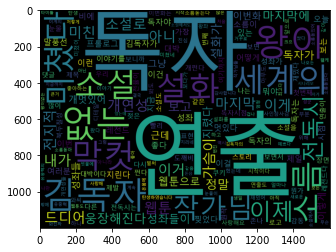

In [65]:
cnt = Counter(list(word_to_index.keys())[:300])
# 한글로 워드클라우드 시각화
from wordcloud import WordCloud
wc = WordCloud(font_path='malgun', width=800, height=600, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(cnt)
plt.figure()
plt.imshow(gen)
wc.to_file("두 단어 이상만.png")

data = ' '.join(list(word_to_index.keys())[:300])

DATA_PATH = './data/'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)    